# Using TensorFlow with Amazon SageMaker training and hosting services

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Train the model](#Train-the-model)
4. [Host the model](#Host-the-model)
5. [Test the model](#Test-the-model)
6. [Clean up](#Clean-up)

## Introduction

The previous lab performed training and prediction directly in the Jupyter notebook environment. With this lab, we transition to leveraging SageMaker's managed training and hosting services. To accomplish this, we use SageMaker's TensorFlow [container](https://sagemaker.readthedocs.io/en/stable/using_tf.html), which lets you provide your training code as a Python script. The container also provides a flexible way for you to customize how inference inputs and outputs are handled over a REST interface.

## Setup

Before preparing the data, there are some initial steps required for setup. To train the image classification algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. Here we will use the execution role the current notebook instance was given when it was created.  This role has necessary permissions, including access to your data in S3.

In [1]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::355151823911:role/service-role/AmazonSageMaker-ExecutionRole-20180515T132694


We also need to identify the S3 bucket that you want to use for providing training and validation datasets.  It will  be used to store the tranied model artifacts as well. In this notebook, we use a default bucket for use with SageMaker in your account. Alternatively, you could use whatever bucket you would like.  We use an object prefix to help organize the bucket content.

In [2]:
bucket = sess.default_bucket() # or use your own custom bucket name
prefix = 'DEMO-TF-image-classification-birds'

# Data Preparation

This notebook assumes you have already downloaded and unpacked the dataset into your notebook instance.

## Set some parameters for the rest of the notebook to use

Here we define a few parameters that help drive the rest of the notebook.  For example, `SAMPLE_ONLY` is defaulted to `True`. This will force the notebook to train on only a handful of species.  Setting `SAMPLE_ONLY` to false will make the notebook work with the entire dataset of 200 bird species.  This makes the training a more difficult challenge, and you will need to tune parameters and run more epochs.

An `EXCLUDE_IMAGE_LIST` is defined as a mechanism to address any corrupt images from the dataset and ensure they do not disrupt the process.

In [3]:
import pandas as pd
import boto3
import json
import pandas as pd

runtime = boto3.client(service_name='runtime.sagemaker')

import matplotlib.pyplot as plt
%matplotlib inline

# To speed up training and experimenting, you can use a small handful of species.
# To see the full list of the classes available, look at the content of CLASSES_FILE.
SAMPLE_ONLY  = True
CLASSES = [13, 17] #, 35, 36, 47, 68, 73, 75, 87, 95, 120, 179, 192]

# Otherwise, you can use the full set of species
if not SAMPLE_ONLY:
    CLASSES = []
    for c in range(200):
        CLASSES += [c + 1]
    prefix = 'DEMO-TF-image-classification-birds-full'

BASE_DIR   = 'CUB_200_2011/'
IMAGES_DIR = BASE_DIR + 'images/'
CLASSES_FILE = BASE_DIR + 'classes.txt'

EXCLUDE_IMAGE_LIST = ['087.Mallard/Mallard_0130_76836.jpg']

SPLIT_RATIOS = (0.6, 0.2, 0.2)

CLASS_COLS      = ['class_number','class_id']

JOB_PREFIX     = 'mpr-tf-ic'

Show the list of bird species or dataset classes the model will be trained to predict.

In [4]:
classes_df = pd.read_csv(CLASSES_FILE, sep=' ', names=CLASS_COLS, header=None)
criteria = classes_df['class_number'].isin(CLASSES)
classes_df = classes_df[criteria]

class_name_list = sorted(classes_df['class_id'].unique().tolist())
print(class_name_list)

['013.Bobolink', '017.Cardinal']


# Create train/val/test dataframes from our dataset

In [5]:
from utils import split
train_df, val_df, test_df = split.get_train_val_dataframes(BASE_DIR, CLASSES, EXCLUDE_IMAGE_LIST, SPLIT_RATIOS)

Using 117 images from 2 classes
num images total: 11788

num train: 70
num val: 23
num test: 24


# Prepare the data channels for Amazon SageMaker
When using Amazon SageMaker's managed training service, you need to provide the datasets to the training algorithm. This is primarily handled via populating S3 buckets, and by indicating the location of data channels such as train, test, and validation. You also need to consider the data format. In our case, to keep things simple, we will populate the data channels with folders containing the original JPG images organized by class folders.

In [6]:
CHANNEL_FOLDER = 'data'

Here we populate the local channel folders, and we handle re-populating in case we have already run through this notebook with a different subset of bird species. The local content will be synchronized to our s3 bucket for access by the SageMaker training service. For a large number of classes, this could take a few minutes. You can skip these cells if you are re-running the notebook after already having populated these folders. 

In [7]:
import os
cwd = os.getcwd()

In [8]:
def copy_files_for_channel(df, channel_name, verbose=False):
    print('\nCopying files for {} images in channel: {}...'.format(df.shape[0], channel_name))
    for i in range(df.shape[0]):
        target_fname = df.iloc[i]['image_file_name']
        if verbose:
            print(target_fname)
        !cp $cwd/$IMAGES_DIR/$target_fname $cwd/$CHANNEL_FOLDER/$channel_name/$target_fname

In [9]:
if os.path.exists(CHANNEL_FOLDER):
    print('About to remove {}/{}'.format(cwd, CHANNEL_FOLDER))
    perform_delete = input('Are you sure you want to proceed (yes/no)?')
    if perform_delete == 'yes':
        for ch in ['train', 'test', 'validation']:
            !rm -i -rf $CHANNEL_FOLDER/$ch/*
            !rm -i -rf $CHANNEL_FOLDER/$ch
            !mkdir  $CHANNEL_FOLDER/$ch

        for c in class_name_list:
            !mkdir $CHANNEL_FOLDER/train/$c
            !mkdir $CHANNEL_FOLDER/validation/$c
            !mkdir $CHANNEL_FOLDER/test/$c
            
        copy_files_for_channel(val_df,   'validation')
        copy_files_for_channel(test_df,  'test')
        copy_files_for_channel(train_df, 'train')
else:
    print('Channel folder does not yet exist. Creating it.')
    os.mkdir(CHANNEL_FOLDER)
    copy_files_for_channel(val_df,   'validation')
    copy_files_for_channel(test_df,  'test')
    copy_files_for_channel(train_df, 'train')

About to remove /home/ec2-user/SageMaker/recovery/data
Are you sure you want to proceed (yes/no)?no


## Upload content of each data channel to S3
Note that for local mode training, this step is not necessary. SageMaker local mode is helpful for early iterations of the development of a new model. Once the approach is more stable, you typically then use SageMaker training jobs on larger sets of data and with additional epochs.

In [10]:
if input('Are you sure you want to replace your s3 images?') == 'yes':
    print('Clearing out s3://{}/{}/'.format(bucket, prefix))
    for ch in ['train', 'test', 'validation']:
        !aws s3 rm --quiet --recursive s3://$bucket/$prefix/$ch/
    print('\nSynchronizing local data channels with s3...')
    !aws s3 sync $CHANNEL_FOLDER s3://$bucket/$prefix/

print('contents of s3://{}/{}/'.format(bucket, prefix))
!aws s3 ls s3://$bucket/$prefix/

Are you sure you want to replace your s3 images?no
contents of s3://sagemaker-us-east-1-355151823911/DEMO-TF-image-classification-birds/
                           PRE batch-predictions/
                           PRE test/
                           PRE train/
                           PRE validation/


# Train the model 
The custom TensorFlow training code is captured in an external Python script that is passed to SageMaker. It is shown below for completeness in the notebook.

In [11]:
!pygmentize 'code/train-mobilenet.py'

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
LAST_FROZEN_LAYER = 20

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [12]:
!pygmentize code/inference.py

# Copyright 2018 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

import io
import json
import numpy as np
from collections import namedtuple
from PIL import Image

import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from numpy import argmax

import logging
logging.basicConfig(level=logging.DEBUG)

HEIGHT = 224
WIDTH  = 224

Context = namedtuple('Context',
                     'model_name, model_v

When using local mode, this simple setup script is required.

In [13]:
!/bin/bash ./setup.sh

SageMaker instance route table setup is ok. We are good to go.
SageMaker instance routing for Docker is ok. We are good to go!


## Create the SageMaker training job using the TensorFlow container
Here we establish the Tensorflow estimator object. Note that we support SageMaker remote training jobs as well as local mode training. Metric definitions are provided so that you can visualize metrics from the SageMaker console as well as from CloudWatch.

In [46]:
import sagemaker
from sagemaker.tensorflow import TensorFlow
import logging

local = True
if (local):
    train_instance_type = 'local'
    serve_instance_type = 'local'
else:
    train_instance_type = 'ml.p3.8xlarge' 
    serve_instance_type = 'ml.c5.xlarge'

hyperparameters = {'fine_tuning_epochs': 25, 
                   'dropout': 0.5,
                   'data_dir': '/opt/ml/input/data'}

metric_definitions=[{'Name' : 'validation:acc', 
                     'Regex': '.*step.* - val_acc: (.*$)'},
                    {'Name' : 'validation:loss', 
                     'Regex': '- val_loss: (.*?) '},
                   {'Name' : 'acc', 
                     'Regex': '.*step.* - acc: (.*?) '},
                    {'Name' : 'loss', 
                     'Regex': '.*step.* - loss: (.*?) '}]

estimator = TensorFlow(entry_point='train-mobilenet.py',
                       source_dir='code',
                       train_instance_type=train_instance_type,
                       train_instance_count=1,
                       hyperparameters=hyperparameters,
                       metric_definitions=metric_definitions,
                       role=sagemaker.get_execution_role(), # Pass notebook role to container
                       framework_version='1.12', #1.13.1
                       py_version='py3',
                       base_job_name=JOB_PREFIX,
                       script_mode=True)

# 1.12 version gives an error when loading pretrained MobileNetV2 model, complaining about image sizes.
# works fine on 1.13.1
# however, batch fails on 1.13.1 w GPU's

In [47]:
data_dir = os.path.join(os.getcwd(), 'data')
print('Local data dir: {}'.format(data_dir))

if (local):
    train_in = f'file://{data_dir}/train'
    test_in  = f'file://{data_dir}/test'
    val_in   = f'file://{data_dir}/validation'
else:
    s3_base = 's3://{}/{}'.format(bucket, prefix)
    train_in = f'{s3_base}/train'
    test_in  = f'{s3_base}/test'
    val_in   = f'{s3_base}/validation'

inputs = {'train':train_in, 'test': test_in, 'validation': val_in}

print(inputs)

Local data dir: /home/ec2-user/SageMaker/recovery/data
{'train': 'file:///home/ec2-user/SageMaker/recovery/data/train', 'test': 'file:///home/ec2-user/SageMaker/recovery/data/test', 'validation': 'file:///home/ec2-user/SageMaker/recovery/data/validation'}


In [48]:
estimator.fit(inputs) 

Creating tmp47rmugqr_algo-1-ikovz_1 ... 
Attaching to tmp47rmugqr_algo-1-ikovz_12mdone
algo-1-ikovz_1  | 2019-09-08 13:25:25,652 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-ikovz_1  | 2019-09-08 13:25:25,657 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ikovz_1  | 2019-09-08 13:25:25,836 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ikovz_1  | 2019-09-08 13:25:25,849 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-ikovz_1  | 2019-09-08 13:25:25,858 sagemaker-containers INFO     Invoking user script
algo-1-ikovz_1  | 
algo-1-ikovz_1  | Training Env:
algo-1-ikovz_1  | 
algo-1-ikovz_1  | {
algo-1-ikovz_1  |     "additional_framework_parameters": {},
algo-1-ikovz_1  |     "channel_input_dirs": {
algo-1-ikovz_1  |         "train": "/opt/ml/input/data/train",
algo-1-ikovz_1  |         "test": "/opt/ml/input/data/test",
algo-1-ikov

algo-1-ikovz_1  | TF version: 1.12.0
algo-1-ikovz_1  | Keras version: 2.1.6-tf
algo-1-ikovz_1  | Copying inference source files...
algo-1-ikovz_1  | Files after copy:
algo-1-ikovz_1  | ['/opt/ml/model/code/requirements.txt', '/opt/ml/model/code/inference.py']
algo-1-ikovz_1  | args: Namespace(batch_size=16, dropout=0.5, fine_tuning_epochs=25, fine_tuning_lr=0.0001, initial_epochs=5, initial_lr=1e-05, model_dir='s3://sagemaker-us-east-1-355151823911/mpr-tf-ic-2019-09-08-13-25-22-895/model', num_fully_connected_layers=1, test='/opt/ml/input/data/test', train='/opt/ml/input/data/train', validation='/opt/ml/input/data/validation')
algo-1-ikovz_1  | Found 70 images belonging to 2 classes.
algo-1-ikovz_1  | Found 24 images belonging to 2 classes.
algo-1-ikovz_1  | Found 23 images belonging to 2 classes.
algo-1-ikovz_1  | Downloading data from https://github.com/JonathanCMitchell/mobilenet_v2_keras/releases/download/v1.1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5
941260

In [17]:
print('Completed training job: {}'.format(estimator.latest_training_job.name))

Completed training job: mpr-tf-ic-2019-09-08-12-28-54-768


# Host the model

In the simple case, once the fit method is complete, we can simply call deploy to publish the trained model. If iterating on various implementations of `inference.py`, you can avoid having to retrain the model by simply replacing the file inside of the model artifacts. This next cell downloads the model artifacts and runs a script that replaces the file and uploads the updated model artifacts for deployment.

In [36]:
if not local:
    # re-deploy model with new inference.py without having to re-do training job
    from sagemaker.tensorflow.serving import Model

    training_job_name = estimator.latest_training_job.name
    model_artifacts = 's3://{}/{}/output/model.tar.gz'.format(bucket, training_job_name)
    print(model_artifacts)

    !bash ./replace-inference.sh $model_artifacts

s3://sagemaker-us-east-1-355151823911/mpr-tf-ic-2019-09-08-12-28-54-768/output/model.tar.gz
download: s3://sagemaker-us-east-1-355151823911/mpr-tf-ic-2019-09-08-12-28-54-768/output/model.tar.gz to ./model.tar.gz
code/
code/train-mobilenet-SAVE-ERROR.py
code/inference-WITH-LOG.py
code/requirements.txt
code/inference-WORKS.py
code/inference.py
code/train-mobilenet.py
export/
export/Servo/
export/Servo/1/
export/Servo/1/variables/
export/Servo/1/variables/variables.index
export/Servo/1/variables/variables.data-00000-of-00001
export/Servo/1/saved_model.pb
code/
code/train-mobilenet-SAVE-ERROR.py
code/inference-WITH-LOG.py
code/requirements.txt
code/inference-WORKS.py
code/inference.py
code/train-mobilenet.py
export/
export/Servo/
export/Servo/1/
export/Servo/1/variables/
export/Servo/1/variables/variables.index
export/Servo/1/variables/variables.data-00000-of-00001
export/Servo/1/saved_model.pb
upload: ./model.tar.gz to s3://sagemaker-us-east-1-355151823911/mpr-tf-ic-2019-09-08-12-28-54-76

In our example, we are reusing a specific endpoint name. Alternatively, you can let SageMaker create a name dynamically. Since our name is reused, here we make sure that any previous endpoint is deleted along with its automatically generated endpoint configuration.

In [39]:
if not local:
    try:
        client = boto3.client('sagemaker')
        deployment_name = 'tf-bird-classify'
        client.delete_endpoint(EndpointName=deployment_name)
        client.delete_endpoint_config(EndpointConfigName=deployment_name)
    except:
        pass

Here we deploy the updated model artifacts. If iterating on `inference.py`, re-create the model and deploy it. Otherwise, simply deploy the model directly from the estimator. You can use this approach once your `inference.py` code is stable.

In [40]:
if not local:
    model = Model(model_data=model_artifacts, 
              role=sagemaker.get_execution_role())

    predictor = model.deploy(initial_instance_count=1, 
                         instance_type=serve_instance_type,
                         endpoint_name=deployment_name)
else:
    predictor = estimator.deploy(initial_instance_count=1, 
                               instance_type=serve_instance_type,
#                               endpoint_name='tf-bird-classify',
                               endpoint_type='tensorflow-serving')

--------------------------------------------------------------------------!

In [41]:
if local:
    predictor = estimator.deploy(initial_instance_count=1, 
                               instance_type=serve_instance_type,
#                               endpoint_name='tf-bird-classify',
                               endpoint_type='tensorflow-serving')

# Test the model 

In [42]:
from tensorflow.keras.preprocessing import image
from numpy import argmax

## Predicting using the SageMaker TensorFlow endpoint
When calling your image classifier hosted in a SageMaker endpoint, the call to the predictor is just slightly different:

1. Instead of exposing the implementation detail of a model-specific preprocessing of the image, we simply pass the image bytes directly.
2. We indicate the content type for the rest call, in this case `application/x-image`.
3. The results come back as a json document with a `predictions` object.

The rest of the code remains the same.

In [43]:
from IPython.display import Image, display
def predict_bird_from_file(fn, verbose=True):
    with open(fn, 'rb') as img:
        f = img.read()
    x = bytearray(f)
    
    predictor.content_type = 'application/x-image'
    predictor.serializer   = None
    
    results = predictor.predict(x)['predictions']

    predicted_class_idx = argmax(results)
    predicted_class = class_name_list[predicted_class_idx]
    confidence = results[0][predicted_class_idx]
    if verbose:
        display(Image(fn))
        print('Class: {}, confidence: {:.2f}'.format(predicted_class, confidence))
    del img, x
    return predicted_class_idx, confidence

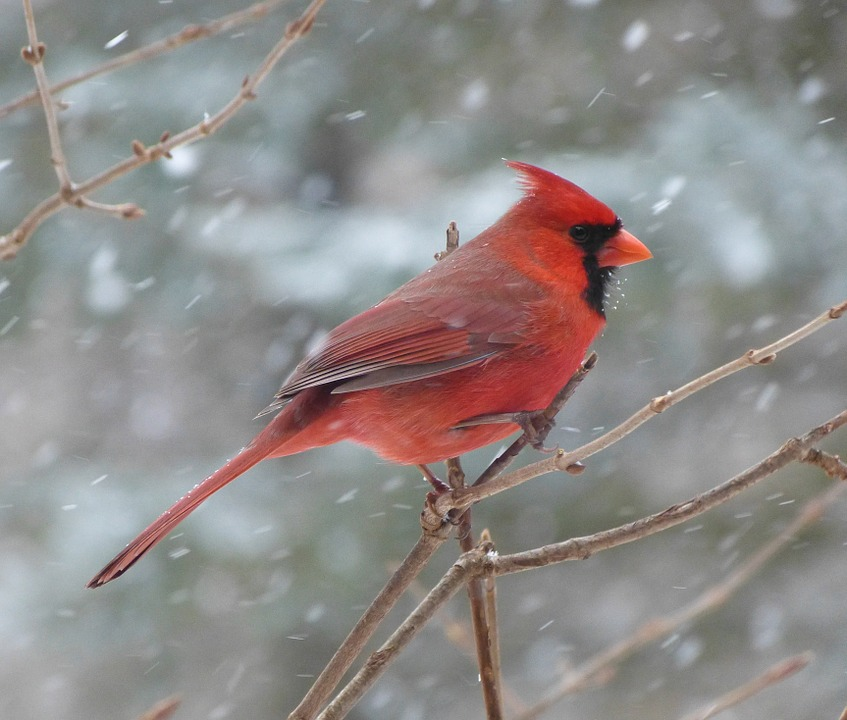

Class: 017.Cardinal, confidence: 1.00


(1, 0.999998)

In [44]:
predict_bird_from_file('northern-cardinal-1.jpg')
## "Reshape cannot infer the missing input size for an empty tensor unless all specified input sizes are non-zero\n\t 
##[[{{node model_2/flatten/Reshape}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _output_shapes=[[?,62720]],
##_device=\"/job:localhost/replica:0/task:0/device:CPU:0\"](model_2/out_relu/Relu6, model_2/flatten/Reshape/shape)]]

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.GnBu):
    plt.figure(figsize=(7,7))
    plt.grid(False)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), 
                                  range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.gca().set_xticklabels(class_name_list)
    plt.gca().set_yticklabels(class_name_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
from sklearn.metrics import confusion_matrix
def create_and_plot_confusion_matrix(actual, predicted):
    cnf_matrix = confusion_matrix(actual, np.asarray(predicted),labels=range(len(class_name_list)))
    plot_confusion_matrix(cnf_matrix, classes=range(len(class_name_list)))

### Assess prediction performance against validation and test datasets

In [35]:
from IPython.display import Image, display

# Iterate through entire dataframe, tracking predictions and accuracy. For mistakes, show the image, and the predicted and actual classes to help understand
# where the model may need additional tuning.

def test_image_df(df):
    print('Testing {} images'.format(df.shape[0]))
    num_errors = 0
    preds = []
    acts  = []
    for i in range(df.shape[0]):
        fname = df.iloc[i]['image_file_name']
        act   = int(df.iloc[i]['class_id']) - 1
        acts.append(act)
        pred, conf = predict_bird_from_file(IMAGES_DIR + '/' + fname, verbose=False)
        preds.append(pred)
        if (pred != act):
            num_errors += 1
            print('ERROR on image index {} -- Pred: {} {:.2f}, Actual: {}'.format(i, 
                                                                   class_name_list[pred], conf, 
                                                                   class_name_list[act]))
            display(Image(filename=IMAGES_DIR + '/' + fname))
    return num_errors, preds, acts

In [36]:
num_images = val_df.shape[0]
num_errors, preds, acts = test_image_df(val_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

Testing 23 images

Accuracy: 1.00, 23/23


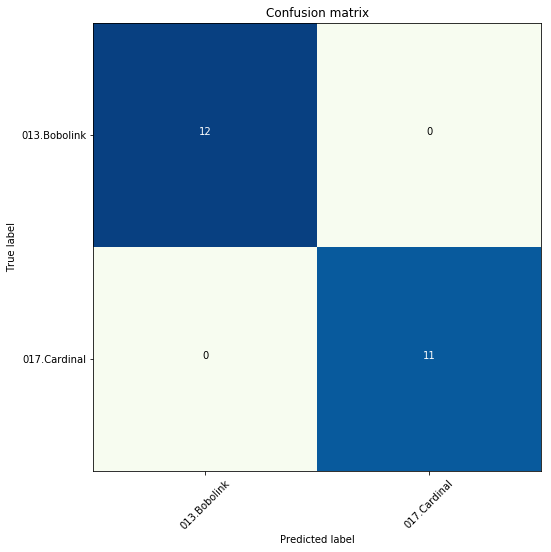

In [37]:
create_and_plot_confusion_matrix(acts, preds)

In [38]:
num_images = test_df.shape[0]
num_errors, preds, acts = test_image_df(test_df)
print('\nAccuracy: {:.2f}, {}/{}'.format(1 - (num_errors/num_images), num_images - num_errors, num_images))

Testing 24 images

Accuracy: 1.00, 24/24


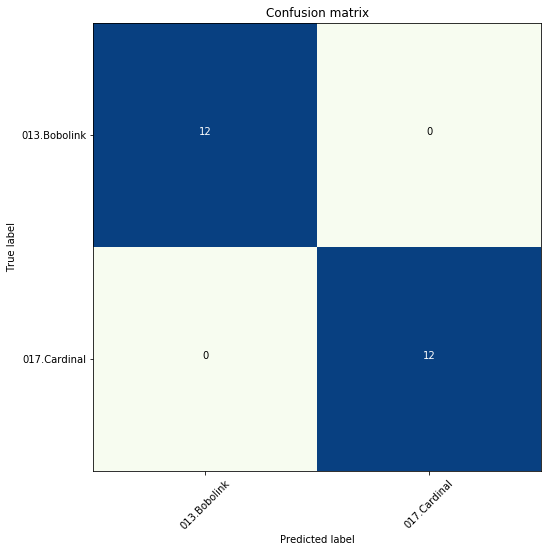

In [39]:
create_and_plot_confusion_matrix(acts, preds)

### Test model against previously unseen images
Here we download images that the algorithm has not yet seen.

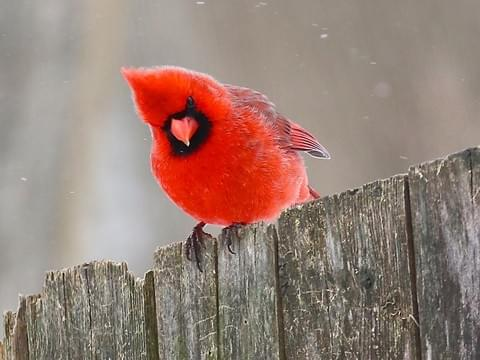

Class: 017.Cardinal, confidence: 1.00


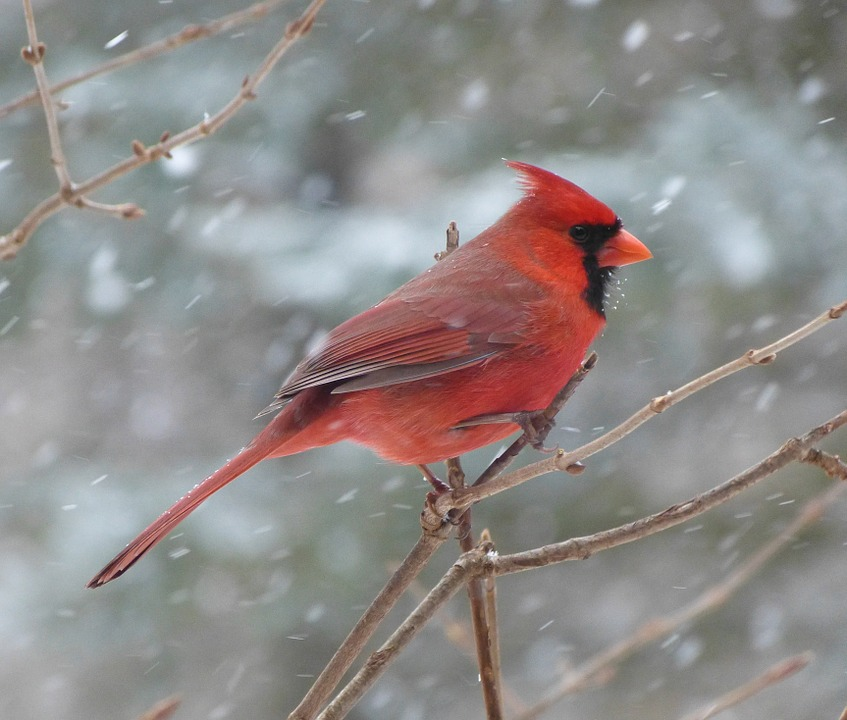

Class: 017.Cardinal, confidence: 1.00


(1, 0.999999)

In [40]:
predict_bird_from_file('northern-cardinal-2.jpg')
predict_bird_from_file('northern-cardinal-1.jpg')

# Clean up
To avoid being billed for an idle endpoint, here we delete the endpoint.

In [45]:
predictor.delete_endpoint()